# **Data Explorattion**

**Mục tiêu**:

- Hiểu cấu trúc dữ liệu: số dòng, số cột, danh sách và ý nghĩa các features.
- Đánh giá chất lượng dữ liệu: missing, invalid, cardinality, outliers.
- Phân tích phân phối của từng feature (numeric & categorical).
- Phân tích mối quan hệ giữa feature với nhau và với biến mục tiêu `target`.
- Rút ra các insight & câu hỏi nghiên cứu để chuẩn bị cho preprocessing và modeling.

## Import thư viện

In [52]:
import os
import sys
import numpy as np

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.visualization import (
    plot_missing_bar,
    plot_outliers,
    plot_target_distribution,
    plot_numeric_distribution,
    plot_ecdf,
    plot_categorical_distribution,
    plot_pie,
    plot_target_rate_by_category,
    boxplot_numeric_by_target,
    plot_hist_overlay_by_target,
    plot_scatter,
    plot_scatter_matrix,
    plot_correlation_heatmap,
    plot_line,
)

np.set_printoptions(suppress=True)

## I. Chuẩn bị dữ liệu & Thông tin tổng quan

**Ở phần này sẽ thực hiện các công việc sau:**

- Load file CSV vào NumPy.
- Tách header và data.
- In ra số dòng, số cột.
- Liệt kê danh sách các feature.

### Load dữ liệu

In [53]:
DATA_PATH = os.path.join(PROJECT_ROOT, "data", "raw", "aug_train.csv")

with open(DATA_PATH, "r", encoding="utf-8") as f:
    header = f.readline().strip().split(",")

data = np.genfromtxt(
    DATA_PATH,
    delimiter=",",
    dtype=str,
    skip_header=1
)

print("Xem thử 5 dòng đầu của bộ dữ liệu:")
for i in range(5):
    print(data[i])

Xem thử 5 dòng đầu của bộ dữ liệu:
['8949' 'city_103' '0.92' 'Male' 'Has relevent experience' 'no_enrollment'
 'Graduate' 'STEM' '>20' '' '' '1' '36' '1.0']
['29725' 'city_40' '0.7759999999999999' 'Male' 'No relevent experience'
 'no_enrollment' 'Graduate' 'STEM' '15' '50-99' 'Pvt Ltd' '>4' '47' '0.0']
['11561' 'city_21' '0.624' '' 'No relevent experience' 'Full time course'
 'Graduate' 'STEM' '5' '' '' 'never' '83' '0.0']
['33241' 'city_115' '0.789' '' 'No relevent experience' '' 'Graduate'
 'Business Degree' '<1' '' 'Pvt Ltd' 'never' '52' '1.0']
['666' 'city_162' '0.767' 'Male' 'Has relevent experience' 'no_enrollment'
 'Masters' 'STEM' '>20' '50-99' 'Funded Startup' '4' '8' '0.0']


### Thông tin tổng quan

In [54]:
DATA_PATH = os.path.join(PROJECT_ROOT, "data", "raw", "aug_train.csv")

with open(DATA_PATH, "r", encoding="utf-8") as f:
    header = f.readline().strip().split(",")

data = np.genfromtxt(
    DATA_PATH,
    delimiter=",",
    dtype=str,
    skip_header=1,
    encoding="utf-8",
)

num_rows, num_cols = data.shape

print(f"Số dòng (samples): {num_rows}")
print(f"Số cột  (features): {num_cols}\n")

print("Danh sách features:")
for i, col in enumerate(header):
    print(f"{i:2d}. {col}")

Số dòng (samples): 19158
Số cột  (features): 14

Danh sách features:
 0. enrollee_id
 1. city
 2. city_development_index
 3. gender
 4. relevent_experience
 5. enrolled_university
 6. education_level
 7. major_discipline
 8. experience
 9. company_size
10. company_type
11. last_new_job
12. training_hours
13. target


#### Ý nghĩa của các features
- **enrollee_id** — ID ứng viên (unique identifier).
- **city** — mã thành phố ứng viên sinh sống.
- **city_development_index** — mức độ phát triển của thành phố (0–1).
- **gender** — giới tính của ứng viên.
- **relevent_experience** — ứng viên có kinh nghiệm liên quan hay không.
- **enrolled_university** — ứng viên đang theo học loại chương trình đại học nào.
- **education_level** — trình độ học vấn cao nhất.
- **major_discipline** — chuyên ngành học.
- **experience** — số năm kinh nghiệm làm việc.
- **company_size** — quy mô công ty nơi ứng viên làm việc.
- **company_type** — loại hình doanh nghiệp.
- **last_new_job** — số năm kể từ công việc trước.
- **training_hours** — số giờ đào tạo đã hoàn thành.
- **target** — 1 nếu ứng viên muốn đổi việc; 0 nếu không.

## II. Tổng quan về các đặc trưng của bộ dữ liệu

**Phần này sẽ thực hiện các nhiệm vụ sau:**
- Kiểm tra duplicate rows cũng như duplicate IDs
- Ước lượng kiểu dữ liệu hiện tại cho từng cột: Numeric vs Categorical.
- Tính số lượng giá trị khác nhau cho từng cột.
- Đếm số lượng missing values ở từng cột.
- Vẽ biểu đồ bar cho missing values (`plot_missing_bar`).
- Kiểm tra sơ bộ các giá trị không hợp lệ:
  - Numeric nhưng chứa text kỳ lạ (vd: `'??'`, `'unknown'`).

### Helper functions

In [55]:
MISSING_TOKENS = {"", " ", "nan", "NaN", "NULL", "null", "NA", "?"}

def is_missing(x: str) -> bool:
    return x in MISSING_TOKENS

def is_float(x: str) -> bool:
    try:
        float(x)
        return True
    except:
        return False

col_idx_map = {name: idx for idx, name in enumerate(header)}

def get_col(col_name: str) -> np.ndarray:
    return data[:, col_idx_map[col_name]]


### Kiểm tra duplicate rows & duplicate IDs

In [56]:
# Duplicate rows
rows_str = np.array(["||".join(row) for row in data])
unique_rows, counts_rows = np.unique(rows_str, return_counts=True)
num_dup_rows = np.sum(counts_rows > 1)
print("Số lượng dòng trùng nhau:", num_dup_rows)

# Duplicate enrollee_id (nếu có cột này)
if "enrollee_id" in header:
    enrollee_ids = get_col("enrollee_id")
    unique_ids, counts_ids = np.unique(enrollee_ids, return_counts=True)
    num_dup_ids = np.sum(counts_ids > 1)
    print("Số enrollee_id bị trùng:", num_dup_ids)

Số lượng dòng trùng nhau: 0
Số enrollee_id bị trùng: 0


### Nhận dạng kiểu dữ liệu

In [57]:
numeric_cols_raw = []
categorical_cols_raw = []
cardinality = {}

for j in range(num_cols):
    col_name = header[j]
    col_data = data[:, j]
    non_missing = np.array([x for x in col_data if not is_missing(x)])

    if len(non_missing) > 0:
        cardinality[col_name] = len(np.unique(non_missing))
    else:
        cardinality[col_name] = 0

    if len(non_missing) == 0:
        categorical_cols_raw.append(col_name)
        continue

    sample_size = min(30, len(non_missing))
    sample = np.random.choice(non_missing, size=sample_size, replace=False)
    numeric_ratio = np.mean([is_float(x) for x in sample])

    if numeric_ratio > 0.8:
        numeric_cols_raw.append(col_name)
    else:
        categorical_cols_raw.append(col_name)

max_len = max(len("Tên cột"), max(len(col) for col in header))

print("=" * (max_len + 20))
print(f"{'Tên cột'.ljust(max_len)} | Kiểu dữ liệu")
print("-" * (max_len + 20))

for col in numeric_cols_raw:
    print(f"{col.ljust(max_len)} | Numeric")

for col in categorical_cols_raw:
    print(f"{col.ljust(max_len)} | Categorical")

print("=" * (max_len + 20))

Tên cột                | Kiểu dữ liệu
------------------------------------------
enrollee_id            | Numeric
city_development_index | Numeric
training_hours         | Numeric
target                 | Numeric
city                   | Categorical
gender                 | Categorical
relevent_experience    | Categorical
enrolled_university    | Categorical
education_level        | Categorical
major_discipline       | Categorical
experience             | Categorical
company_size           | Categorical
company_type           | Categorical
last_new_job           | Categorical


### Số lượng các giá trị khác nhau (Unique value)

In [58]:
print("Số lượng các giá trị khác nhau cho từng feature (unique value):")
for name in header:
    print(f"{name:30s}: {cardinality[name]}")

Số lượng các giá trị khác nhau cho từng feature (unique value):
enrollee_id                   : 19158
city                          : 123
city_development_index        : 93
gender                        : 3
relevent_experience           : 2
enrolled_university           : 3
education_level               : 5
major_discipline              : 6
experience                    : 22
company_size                  : 8
company_type                  : 6
last_new_job                  : 6
training_hours                : 241
target                        : 2


### Kiểm tra missing values

In [59]:
missing_counts = np.zeros(num_cols, dtype=int)

for j in range(num_cols):
    col_data = data[:, j]
    missing_counts[j] = np.sum([is_missing(x) for x in col_data])

missing_ratios = missing_counts / num_rows

col_width_name = max(max(len(name) for name in header), len("Feature"))
col_width_cnt = max(max(len(str(c)) for c in missing_counts), len("Missing"))
col_width_ratio = len("Ratio")

print("=" * (col_width_name + col_width_cnt + col_width_ratio + 10))
print(f"{'Feature'.ljust(col_width_name)} | "
      f"{'Missing'.rjust(col_width_cnt)} | "
      f"{'Ratio'}")
print("-" * (col_width_name + col_width_cnt + col_width_ratio + 10))

for name, cnt, ratio in zip(header, missing_counts, missing_ratios):
    print(f"{name.ljust(col_width_name)} | "
          f"{str(cnt).rjust(col_width_cnt)} | "
          f"{ratio:6.3f}")

print("=" * (col_width_name + col_width_cnt + col_width_ratio + 10))


Feature                | Missing | Ratio
--------------------------------------------
enrollee_id            |       0 |  0.000
city                   |       0 |  0.000
city_development_index |       0 |  0.000
gender                 |    4508 |  0.235
relevent_experience    |       0 |  0.000
enrolled_university    |     386 |  0.020
education_level        |     460 |  0.024
major_discipline       |    2813 |  0.147
experience             |      65 |  0.003
company_size           |    5938 |  0.310
company_type           |    6140 |  0.320
last_new_job           |     423 |  0.022
training_hours         |       0 |  0.000
target                 |       0 |  0.000


### Bar chart

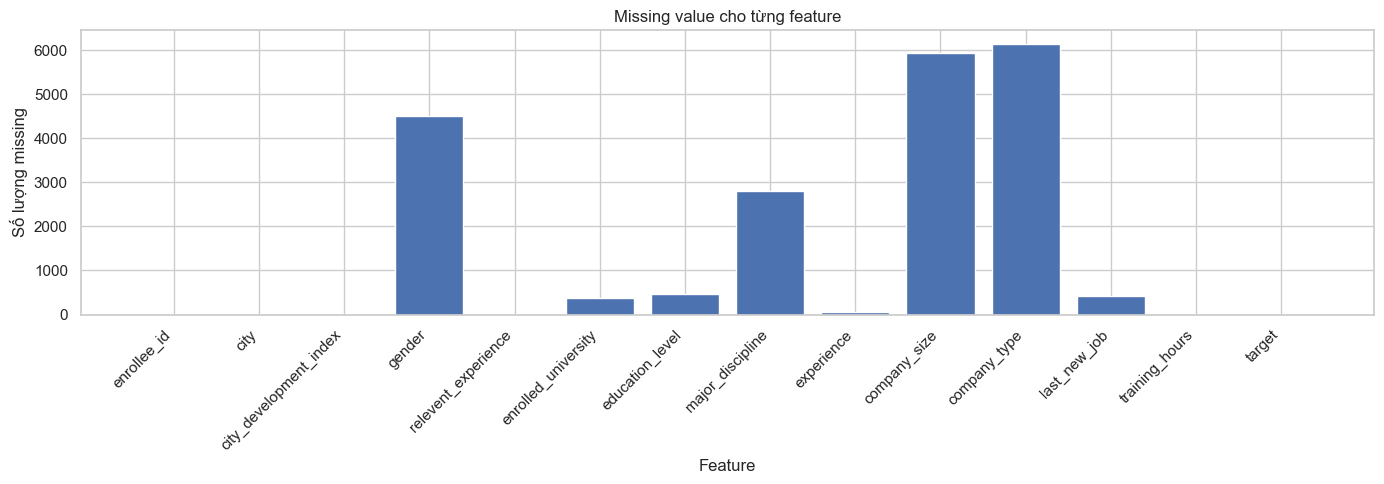

In [60]:
plot_missing_bar(header, missing_counts)

### Kiểm tra invalid values cho các cột kiểu numeric

In [61]:
print("Kiểm tra invalid value:")
is_invalid = False
for col_name in numeric_cols_raw:
    col = get_col(col_name)
    invalid_mask = [(not is_missing(x)) and (not is_float(x)) for x in col]
    invalid_vals = col[invalid_mask]
    if len(invalid_vals) > 0:
        is_invalid = True
        uniq, cnts = np.unique(invalid_vals, return_counts=True)
        print(f"\n[{col_name}] có giá trị không parse được sang float:")
        for u, c in zip(uniq, cnts):
            print(f"  '{u}' : {c} lần")
            
if is_invalid == False:
    print("Không tìm thấy.")

Kiểm tra invalid value:
Không tìm thấy.


## II. Thống kê mô tả cho từng feature
**Mục tiêu của phần này:**

- Tóm tắt **hình dạng và phạm vi giá trị** của các biến trong dataset,
- Giúp ta có được cái nhìn tổng quan:
  - Numeric: giá trị nhỏ nhất, lớn nhất, trung bình, độ lệch chuẩn, và các phân vị (percentiles).
  - Categorical: có bao nhiêu loại giá trị khác nhau, những category nào xuất hiện nhiều nhất và chiếm tỷ lệ bao nhiêu.

Cụ thể:

#### 1. Đối với biến **numeric**

- Chuyển các cột số (đang đọc dưới dạng chuỗi) về dạng số thực (`float`), với:
  - Giá trị hợp lệ → số,
  - Giá trị không hợp lệ / thiếu → `NaN` (đã xử lý phần missing trước đó).
- Tính cho mỗi biến:
  - `min`, `max`
  - các phân vị: `5%`, `25%`, `50%` (median), `75%`, `95%`
  - `mean`, `std`
- Qua đó ta biết:
  - Biến nằm trong khoảng giá trị nào,
  - Có bị lệch mạnh không,
  - Có giá trị cực trị hay không.

#### 2. Đối với biến **categorical**
- Với từng cột:
  - Đếm số lượng category khác nhau,
  - Liệt kê **top-k category xuất hiện nhiều nhất**:
    - Số lần xuất hiện,
    - Tỷ lệ trên toàn bộ tập dữ liệu.
- Qua đó ta biết:
  - Biến có ít hay nhiều category (low/high cardinality),
  - Có bị **mất cân bằng mạnh** ở một vài category hay không,
  - Hỗ trợ quyết định cách encode (one-hot, gộp nhóm, v.v.) ở bước preprocessing.

---
### **Thống kê mô tả cho categorical**

In [62]:
def describe_categorical(col_name: str, top_k: int = 5):
    col = get_col(col_name)
    n_total = col.shape[0]
    
    non_missing = np.array([x for x in col if not is_missing(x)])
    n_non_missing = len(non_missing)
    
    print(f"Feature '{col_name}':")
    print(f"Tổng số giá trị hợp lệ (non-missing): {n_non_missing} / {n_total}")
    
    if n_non_missing == 0:
        print("-> Cột này không có giá trị hợp lệ để thống kê.")
        return
    
    # Phân phối category
    values, counts = np.unique(non_missing, return_counts=True)
    n_unique = len(values)
    print(f"Số lượng category khác nhau         : {n_unique}")
    
    # Sắp xếp giảm dần theo tần suất
    idx_sorted = np.argsort(-counts)
    values = values[idx_sorted]
    counts = counts[idx_sorted]
    
    # Tỷ lệ dựa trên toàn bộ số dòng (n_total) cho dễ so sánh với các biến khác
    ratios = counts / n_total
    
    k = min(top_k, n_unique)
    print(f"Top {k} category xuất hiện nhiều nhất:")
    print(f"{'Category':24s} | {'Count':>8s} | {'Ratio':>8s}")
    print("-" * 42)
    for v, c, r in zip(values[:k], counts[:k], ratios[:k]):
        print(f"{v:24s} | {c:8d} | {r:8.3f}")
    
    if n_unique > k:
        other_count = counts[k:].sum()
        other_ratio = other_count / n_total
        print("-" * 42)
        print(f"{'(others)':24s} | {other_count:8d} | {other_ratio:8.3f}")
    print("="*55)

In [63]:
categorical_to_describe = [
    "gender",
    "education_level",
    "major_discipline",
    "company_size",
    "company_type",
    "enrolled_university",
    "relevent_experience",
    "city",
]
print("="*55)
for col_name in categorical_to_describe:
    describe_categorical(col_name, top_k=3)

Feature 'gender':
Tổng số giá trị hợp lệ (non-missing): 14650 / 19158
Số lượng category khác nhau         : 3
Top 3 category xuất hiện nhiều nhất:
Category                 |    Count |    Ratio
------------------------------------------
Male                     |    13221 |    0.690
Female                   |     1238 |    0.065
Other                    |      191 |    0.010
Feature 'education_level':
Tổng số giá trị hợp lệ (non-missing): 18698 / 19158
Số lượng category khác nhau         : 5
Top 3 category xuất hiện nhiều nhất:
Category                 |    Count |    Ratio
------------------------------------------
Graduate                 |    11598 |    0.605
Masters                  |     4361 |    0.228
High School              |     2017 |    0.105
------------------------------------------
(others)                 |      722 |    0.038
Feature 'major_discipline':
Tổng số giá trị hợp lệ (non-missing): 16345 / 19158
Số lượng category khác nhau         : 6
Top 3 category xuất hiện 

### **Thống kê mô tả cho numeric**
Để có thể thống kê mô tả cho kiểu numeric ở bộ dữ liệu này ta cần biến đổi giá trị của các cột sang dạng số. Khi quan sát dữ liệu gốc, ta thấy:

- Một số cột **thực chất là số nhưng được lưu dưới dạng chuỗi** trong file CSV.
- Nếu giữ nguyên dạng chuỗi, ta không thể:
  - Tính được các thống kê như min, max, mean, percentiles,
  - Cũng như không thể vẽ đúng histogram, boxplot, hay kiểm tra outlier.

Cụ thể trong bộ dữ liệu này:

1. **`city_development_index`**  
   - Giá trị nhìn qua đã là số (dạng thập phân, từ 0 đến 1).  
   - Mục tiêu: chuyển toàn bộ về số thực (`float`) và giữ lại `NaN` cho các giá trị thiếu → từ đó có thể thống kê các chỉ số cơ bản (min, max, mean, median, phân vị).

2. **`training_hours`**  
   - Là số giờ training hoàn thành, nhưng vẫn được đọc lên dưới dạng chuỗi.  
   - Dữ liệu chủ yếu là số nguyên không âm, đôi khi có giá trị thiếu.  
   - Ta chuyển toàn bộ sang dạng số (`float`) và đánh dấu các giá trị thiếu bằng `NaN` → phục vụ việc:
     - Tính phân bố (histogram, ECDF),
     - So sánh giữa nhóm đổi job và không đổi job.

3. **`experience`**  
   - Đây là cột thú vị: giá trị không phải số thuần mà ở dạng text như `"<1"`, `">20"`, `"5"`, `"10"`, v.v.  
   - Điều này khiến ta **không thể thống kê trực tiếp** nếu giữ nguyên chuỗi.  
   - Dựa trên ý nghĩa:
     - `"<1"` thể hiện kinh nghiệm rất ít, ta coi như ~0 năm → ánh xạ về một giá trị số nhỏ (ví dụ 0).
     - `">20"` thể hiện kinh nghiệm rất nhiều, ta coi như trên 20 năm → ánh xạ về một giá trị đại diện lớn hơn 20.
     - Các giá trị còn lại như `"5"`, `"10"` → giữ nguyên nhưng chuyển sang dạng số.
   - Sau biến đổi, `experience` trở thành một biến số dạng “số năm kinh nghiệm xấp xỉ”, đủ tốt để:
     - Tính thống kê mô tả,
     - Vẽ biểu đồ,
     - Xem xu hướng kinh nghiệm ảnh hưởng đến việc đổi job.

4. **`target`**  
   - Là biến mục tiêu, với 2 giá trị: `0` (không đổi job) và `1` (muốn đổi job).  
   - Bản chất là một biến nhị phân, nhưng vẫn được đọc lên như chuỗi `"0"`, `"1"`.  
   - Ta chuyển sang dạng số (`0.0`, `1.0`) để:
     - Đếm tần suất từng lớp,
     - Tính tỷ lệ,
     - Dùng trực tiếp cho các phân tích liên quan (numeric vs target, categorical vs target).

In [64]:
def parse_experience(x: str) -> float:
    if is_missing(x):
        return np.nan
    x = x.strip()
    if x.startswith("<"):
        return 0.0
    if x.startswith(">"):
        return 21.0
    if is_float(x):
        return float(x)
    return np.nan

def parse_float_or_nan(x: str) -> float:
    return float(x) if (not is_missing(x) and is_float(x)) else np.nan

def get_numeric_array(col_name: str, parser=parse_float_or_nan):
    col = get_col(col_name)
    out = np.empty(col.shape[0], dtype=float)
    for i, v in enumerate(col):
        out[i] = parser(v)
    return out

In [65]:
cdi = get_numeric_array("city_development_index")
training_hours = get_numeric_array("training_hours")
experience = get_numeric_array("experience", parser=parse_experience)
target = get_numeric_array("target")

numeric_arrays = {
    "city_development_index": cdi,
    "training_hours": training_hours,
    "experience": experience,
}

header_fmt = (
    f"{'Feature':25s} | {'min':>8s} | {'5%':>8s} | {'25%':>8s} | {'50%':>8s} | "
    f"{'75%':>8s} | {'95%':>8s} | {'max':>8s} | {'mean':>8s} | {'std':>8s}"
)

print(header_fmt)
print("-" * len(header_fmt))

row_fmt = (
    "{name:25s} | {min:8.3f} | {p5:8.3f} | {p25:8.3f} | {p50:8.3f} | "
    "{p75:8.3f} | {p95:8.3f} | {max:8.3f} | {mean:8.3f} | {std:8.3f}"
)

for name, arr in numeric_arrays.items():
    x = arr[~np.isnan(arr)]
    if x.size == 0:
        continue

    q5, q25, q50, q75, q95 = np.percentile(x, [5, 25, 50, 75, 95])
    
    print(row_fmt.format(
        name=name,
        min=np.min(x),
        p5=q5,
        p25=q25,
        p50=q50,
        p75=q75,
        p95=q95,
        max=np.max(x),
        mean=np.mean(x),
        std=np.std(x, ddof=1)
    ))


Feature                   |      min |       5% |      25% |      50% |      75% |      95% |      max |     mean |      std
----------------------------------------------------------------------------------------------------------------------------
city_development_index    |    0.448 |    0.624 |    0.740 |    0.903 |    0.920 |    0.926 |    0.949 |    0.829 |    0.123
training_hours            |    1.000 |    7.000 |   23.000 |   47.000 |   88.000 |  188.000 |  336.000 |   65.367 |   60.058
experience                |    0.000 |    1.000 |    4.000 |    9.000 |   16.000 |   21.000 |   21.000 |   10.100 |    6.777


### Xác định Outliers cho numeric 
- Dùng phương pháp IQR (Q1, Q3, IQR) để xác định outlier:
  - `value < Q1 - 1.5 * IQR` hoặc `value > Q3 + 1.5 * IQR`.
- Đếm số lượng outliers ở mỗi feature numeric.

In [66]:
def detect_outliers_iqr(x):
    x = np.asarray(x, dtype=float)
    x_clean = x[~np.isnan(x)]
    if x_clean.size == 0:
        return np.zeros_like(x, dtype=bool)
    q1, q3 = np.percentile(x_clean, [25, 75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    mask_out = (x < lower) | (x > upper)
    return mask_out

print("    SỐ LƯỢNG OUTLIERS THEO TỪNG FEATURE (IQR)")
print("="*50)

header_fmt = f"{'Feature':25s} | {'Outliers':>10s}"
print(header_fmt)
print("-"*50)

row_fmt = "{name:25s} | {out:10d}"

for name, arr in numeric_arrays.items():
    mask_out = detect_outliers_iqr(arr)
    num_out = np.sum(mask_out & ~np.isnan(arr))
    print(row_fmt.format(name=name, out=num_out))

print("="*50)


    SỐ LƯỢNG OUTLIERS THEO TỪNG FEATURE (IQR)
Feature                   |   Outliers
--------------------------------------------------
city_development_index    |         17
training_hours            |        984
experience                |          0


#### Visualization

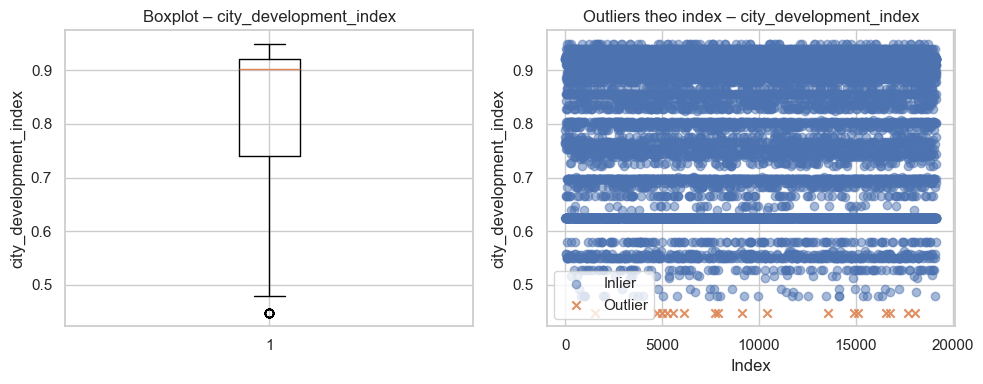

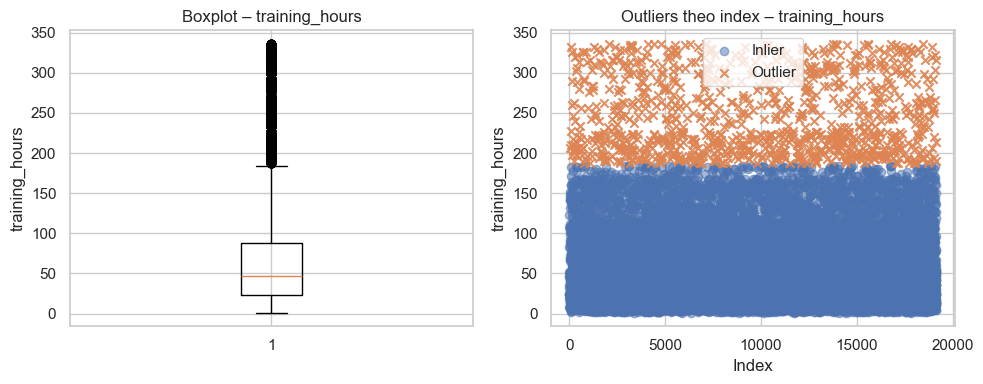

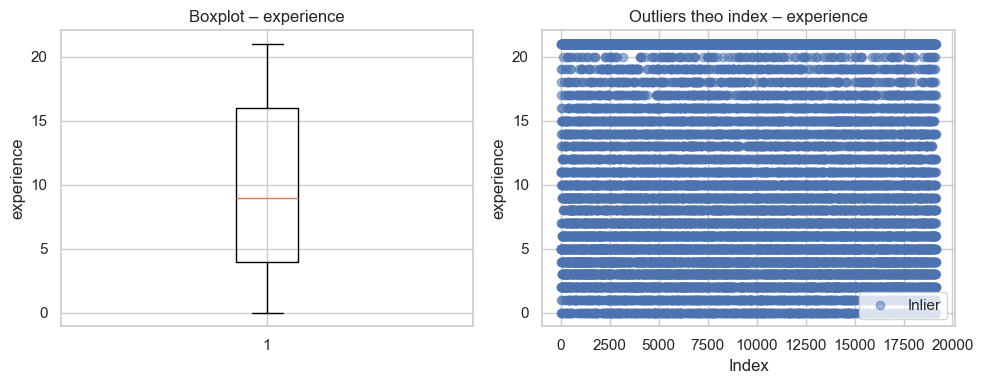

In [67]:
for name, arr in numeric_arrays.items():
    mask_out = detect_outliers_iqr(arr)
    plot_outliers(arr, mask_out, name)

## 

## III. Phân phôi của các feature
### Target

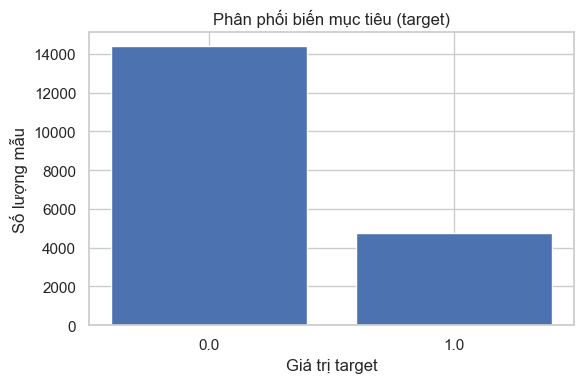

=== Phân phối target ===
target=0 : 14381 mẫu (75.07%)
target=1 : 4777 mẫu (24.93%)


In [68]:
plot_target_distribution(target)

### Phân phối cho numeric


==== city_development_index ====


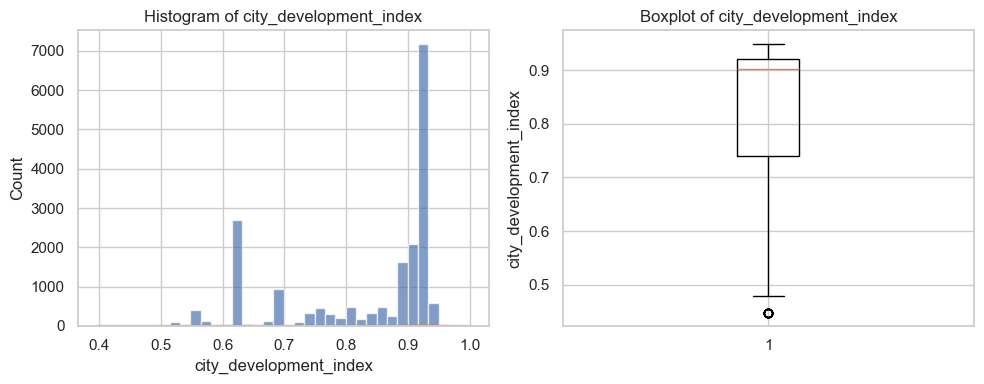

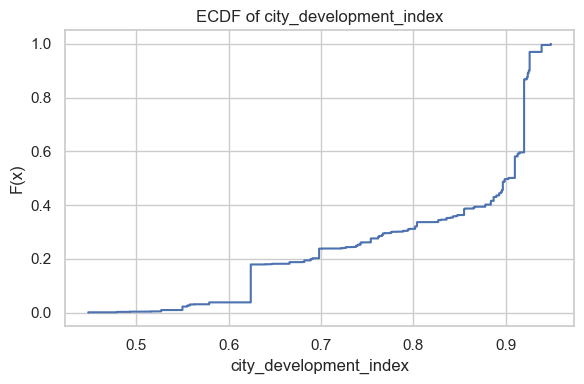


==== training_hours ====


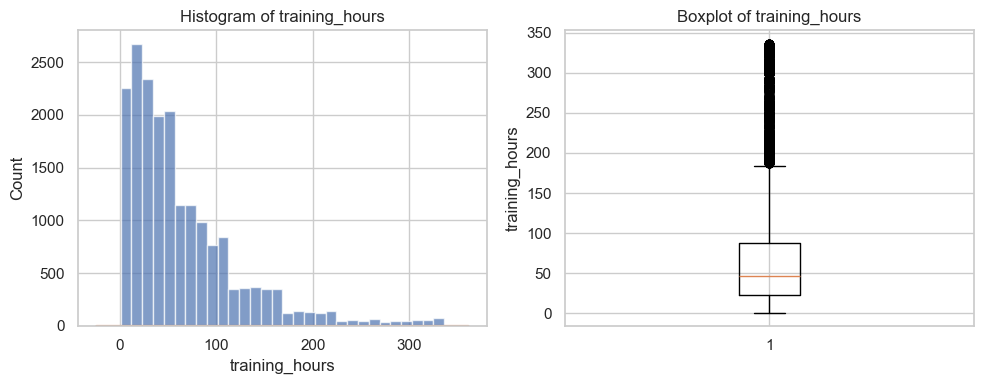

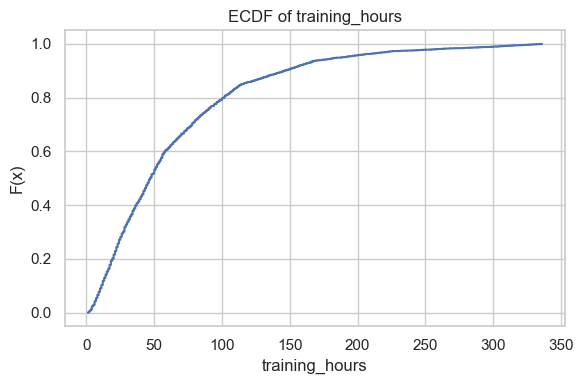


==== experience ====


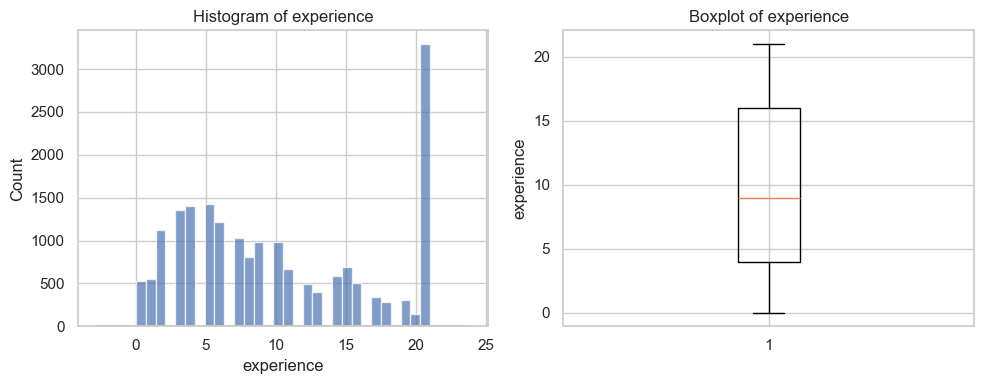

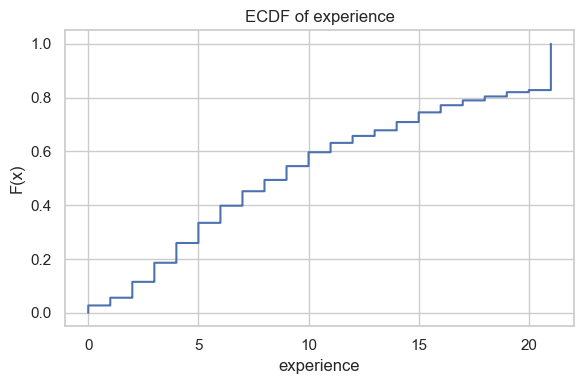

In [69]:
for name, arr in numeric_arrays.items():
    print("\n====", name, "====")
    plot_numeric_distribution(arr, name, bins=30, show_kde=True, log_scale=False)
    plot_ecdf(arr, name)

#